In [3]:
 # Importing required libraries

import pandas as pd
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import image as im
import matplotlib.pyplot as plt
from ipywidgets import interact
import pydicom as pyd
import copy as cp
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
import tensorflow as tf
from tensorflow.keras import models
# from keras.models import load_model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [5]:
# Loading the dataset

data = pd.read_csv("C:/Users/tharu/OneDrive/Documents/Capstone/jupyter/dataset - New.csv")
print("No. of columns in the dataset: ", data.shape[1])
print("No. of rows in the dataset: ", data.shape[0])

No. of columns in the dataset:  7
No. of rows in the dataset:  240


In [6]:
data.head()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax
0,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_1.dcm,858,362,1733,556
1,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_10.dcm,764,423,2414,581
2,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_11.dcm,3,462,2278,652
3,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_12.dcm,1147,439,2466,564
4,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_13.dcm,849,368,1758,579


In [7]:
data.tail()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax
235,./Leaf smut/Leaf_smut_6.jpg,Leaf smut,./segmented-ls/Leaf_smut_6.dcm,1272,358,2360,595
236,./Leaf smut/Leaf_smut_60.jpg,Leaf smut,./segmented-ls/Leaf_smut_60.dcm,227,313,2447,679
237,./Leaf smut/Leaf_smut_7.jpg,Leaf smut,./segmented-ls/Leaf_smut_7.dcm,356,349,2812,727
238,./Leaf smut/Leaf_smut_8.jpg,Leaf smut,./segmented-ls/Leaf_smut_8.dcm,266,139,2845,679
239,./Leaf smut/Leaf_smut_9.jpg,Leaf smut,./segmented-ls/Leaf_smut_9.dcm,310,366,1260,695


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
Images          240 non-null object
Disease         240 non-null object
Dicom Images    240 non-null object
Xmin            240 non-null object
Ymin            240 non-null object
Xmax            240 non-null object
Ymax            240 non-null object
dtypes: object(7)
memory usage: 13.2+ KB


In [9]:
# Exploratory data analysis

data_na = (data.isnull().sum()*100)/len(data)
print("% of missing data in each feature:")
data_na.sort_values(ascending=False)

% of missing data in each feature:


Ymax            0.0
Xmax            0.0
Ymin            0.0
Xmin            0.0
Dicom Images    0.0
Disease         0.0
Images          0.0
dtype: float64

In [10]:
data['Disease'].value_counts()

Healthy leaf             60
Brown spot               60
Leaf smut                60
Bacterial leaf blight    60
Name: Disease, dtype: int64

In [11]:
data[data.Disease=="Healthy leaf"].head()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax
120,./Healthy leaf/Healthy_leaf_1.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_1.dcm,?,?,?,?
121,./Healthy leaf/Healthy_leaf_10.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_10.dcm,?,?,?,?
122,./Healthy leaf/Healthy_leaf_11.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_11.dcm,?,?,?,?
123,./Healthy leaf/Healthy_leaf_12.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_12.dcm,?,?,?,?
124,./Healthy leaf/Healthy_leaf_13.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_13.dcm,?,?,?,?


In [12]:
data['Xmax'][data.Disease=='Healthy leaf'] = 0
data['Ymax'][data.Disease=='Healthy leaf'] = 0
data['Xmin'][data.Disease=='Healthy leaf'] = 0
data['Ymin'][data.Disease=='Healthy leaf'] = 0

data.Xmax = data.Xmax.astype("int64")
data.Ymax = data.Ymax.astype("int64")
data.Xmin = data.Xmin.astype("int64")
data.Ymin = data.Ymin.astype("int64")

In [13]:
# Performing one-hot encoding

df = cp.deepcopy(data)
df['Disease'] = df['Disease'].astype('category')
dummies = pd.get_dummies(df['Disease'],prefix='Disease')
df = pd.concat([df, dummies], axis=1)

In [14]:
# Data engineering -> creating new features in the dataset

for i in range(len(df)):
    if df['Disease'][i]=='Healthy leaf':
        df['object_present'] = 0
    else:
        df['object_present'] = 1

In [15]:
width, height = [], []

for i in range(len(df)):
    img = im.imread(df.Images[i])
    width.append(img.shape[0])
    height.append(img.shape[1])
    
df['Image_width'] = width
df['Image_height'] = height

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 14 columns):
Images                           240 non-null object
Disease                          240 non-null category
Dicom Images                     240 non-null object
Xmin                             240 non-null int64
Ymin                             240 non-null int64
Xmax                             240 non-null int64
Ymax                             240 non-null int64
Disease_Bacterial leaf blight    240 non-null uint8
Disease_Brown spot               240 non-null uint8
Disease_Healthy leaf             240 non-null uint8
Disease_Leaf smut                240 non-null uint8
object_present                   240 non-null int64
Image_width                      240 non-null int64
Image_height                     240 non-null int64
dtypes: category(1), int64(7), object(2), uint8(4)
memory usage: 18.3+ KB


In [17]:
df

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax,Disease_Bacterial leaf blight,Disease_Brown spot,Disease_Healthy leaf,Disease_Leaf smut,object_present,Image_width,Image_height
0,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_1.dcm,858,362,1733,556,1,0,0,0,1,897,3081
1,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_10.dcm,764,423,2414,581,1,0,0,0,1,897,3081
2,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_11.dcm,3,462,2278,652,1,0,0,0,1,897,3081
3,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_12.dcm,1147,439,2466,564,1,0,0,0,1,897,3081
4,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_13.dcm,849,368,1758,579,1,0,0,0,1,897,3081
5,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_14.dcm,1247,339,3049,566,1,0,0,0,1,897,3081
6,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_15.dcm,272,362,2639,487,1,0,0,0,1,897,3081
7,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_16.dcm,585,320,2653,502,1,0,0,0,1,897,3081
8,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_17.dcm,1145,450,2474,550,1,0,0,0,1,897,3081
9,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_18.dcm,789,402,2564,570,1,0,0,0,1,897,3081


In [18]:
# Visualizing original image 

@interact(i=(0,len(df)-1))
def openfile(i):
    data = im.imread(df.Images[i])
    print(df.Disease[i])
    
    # summarize shape of the pixel array
    print(data.dtype)
    print(data.shape)
    print(type(data))
    
    start_point = (df.Xmin[i], df.Ymin[i])    # (xmin, ymin)
    end_point = (df.Xmax[i], df.Ymax[i])      # (xmax, ymax)
    color = (255, 0, 0)                       # RGB
    thickness = 2
    data = cv2.rectangle(data, start_point, end_point, color, thickness)
    
    # display the array of pixels as an image
    plt.imshow(data)
    plt.show()

interactive(children=(IntSlider(value=119, description='i', max=239), Output()), _dom_classes=('widget-interac…

In [19]:
# Visualizing segmented image

@interact(i=(0,len(df)-1))
def openfile(i):
    image_path = df["Dicom Images"][i]
    ds = pyd.dcmread(image_path)
    print(ds)
    plt.imshow(ds.pixel_array)
    plt.show()

interactive(children=(IntSlider(value=119, description='i', max=239), Output()), _dom_classes=('widget-interac…

In [20]:
# Splitting the dataset into train and test

ratio = int(0.8 * df.shape[0])
indices = np.random.permutation(df.shape[0])
training_idx, test_idx = indices[:ratio], indices[ratio:]
train, test = df.iloc[training_idx,:], df.iloc[test_idx,:]

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [21]:
train.head()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax,Disease_Bacterial leaf blight,Disease_Brown spot,Disease_Healthy leaf,Disease_Leaf smut,object_present,Image_width,Image_height
0,./Healthy leaf/Healthy_leaf_51.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_51.dcm,0,0,0,0,0,0,1,0,1,551,2661
1,./Healthy leaf/Healthy_leaf_13.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_13.dcm,0,0,0,0,0,0,1,0,1,281,1280
2,./Leaf smut/Leaf_smut_43.jpg,Leaf smut,./segmented-ls/Leaf_smut_43.dcm,1353,886,3237,1745,0,0,0,1,1,2340,4160
3,./Healthy leaf/Healthy_leaf_32.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_32.dcm,0,0,0,0,0,0,1,0,1,2072,2241
4,./Healthy leaf/Healthy_leaf_31.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_31.dcm,0,0,0,0,0,0,1,0,1,1990,1990


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 14 columns):
Images                           192 non-null object
Disease                          192 non-null category
Dicom Images                     192 non-null object
Xmin                             192 non-null int64
Ymin                             192 non-null int64
Xmax                             192 non-null int64
Ymax                             192 non-null int64
Disease_Bacterial leaf blight    192 non-null uint8
Disease_Brown spot               192 non-null uint8
Disease_Healthy leaf             192 non-null uint8
Disease_Leaf smut                192 non-null uint8
object_present                   192 non-null int64
Image_width                      192 non-null int64
Image_height                     192 non-null int64
dtypes: category(1), int64(7), object(2), uint8(4)
memory usage: 14.7+ KB


In [23]:
test.head()

,Images,Disease,Dicom Images,Xmin,Ymin,Xmax,Ymax,Disease_Bacterial leaf blight,Disease_Brown spot,Disease_Healthy leaf,Disease_Leaf smut,object_present,Image_width,Image_height
0,./Brown spot/Brown_spot_44.jpg,Brown spot,./segmented-bs/Brown_spot_44.dcm,1352,346,1785,448,0,1,0,0,1,897,3081
1,./Bacterial leaf blight/Bacterial_leaf_blight_...,Bacterial leaf blight,./segmented-blb/Bacterial_leaf_blight_7.dcm,995,352,2260,604,1,0,0,0,1,897,3081
2,./Brown spot/Brown_spot_49.jpg,Brown spot,./segmented-bs/Brown_spot_49.dcm,49,19,481,218,0,1,0,0,1,244,617
3,./Healthy leaf/Healthy_leaf_49.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_49.dcm,0,0,0,0,0,0,1,0,1,1784,1784
4,./Healthy leaf/Healthy_leaf_9.jpg,Healthy leaf,./segmented-hl/Healthy_leaf_9.dcm,0,0,0,0,0,0,1,0,1,281,1280


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 14 columns):
Images                           48 non-null object
Disease                          48 non-null category
Dicom Images                     48 non-null object
Xmin                             48 non-null int64
Ymin                             48 non-null int64
Xmax                             48 non-null int64
Ymax                             48 non-null int64
Disease_Bacterial leaf blight    48 non-null uint8
Disease_Brown spot               48 non-null uint8
Disease_Healthy leaf             48 non-null uint8
Disease_Leaf smut                48 non-null uint8
object_present                   48 non-null int64
Image_width                      48 non-null int64
Image_height                     48 non-null int64
dtypes: category(1), int64(7), object(2), uint8(4)
memory usage: 3.9+ KB


In [25]:
# Function to normalize bounding box coordinates (PASCAL VOC format)

def normalize(size, box): # box -> (xmin, xmax, ymin, ymax)
    w = size[0]
    h = size[1]
    x1 = box[0] / w
    x2 = box[1] / w
    y1 = box[2] / h
    y2 = box[3] / h
    return (x1, y1, x2, y2)

In [26]:
# Preparing training dataset labels for input

labels = np.zeros(shape = (len(train), 4))
sizes = np.zeros(shape = (len(train), 2))
classes = np.zeros(shape = (len(train), 4))

for i in range(len(train)):
    size = (train['Image_width'][i], train['Image_height'][i])
    box = (train['Xmin'][i], train['Xmax'][i], train['Ymin'][i], train['Ymax'][i])
    bb = normalize(size, box) 
    labels[i] = [bb[0], bb[1], bb[2], bb[3]]
    classes[i] = [train['Disease_Bacterial leaf blight'][i], train['Disease_Brown spot'][i], train['Disease_Healthy leaf'][i], train['Disease_Leaf smut'][i]]
    sizes[i] = [size[0], size[1]]

In [27]:
print(np.shape(labels))
labels

(192, 4)


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.78205128e-01, 2.12980769e-01, 1.38333333e+00, 4.19471154e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.72131148e-01, 6.48298217e-02, 2.00409836e+00, 3.14424635e-01],
       [2.22965440e-02, 8.30899059e-02, 3.19063545e+00, 1.72995781e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.09589041e-01, 3.26975477e-02, 4.98630137e+00, 1.85286104e-01],
       [1.64444444e-01, 3.14166667e-01, 1.04555556e+00, 5.22500000e-01],
       [8.51727982e-01, 1.37293087e-01, 2.69119287e+00, 1.88575138e-01],
       [5.86399108e-01, 1.64881532e-01, 2.13489409e+00, 2.06751055e-01],
       [2.77777778e-02, 9.68342644e-02, 1.41666667e

In [28]:
print(np.shape(sizes))
sizes

(192, 2)


array([[ 551., 2661.],
       [ 281., 1280.],
       [2340., 4160.],
       [2072., 2241.],
       [1990., 1990.],
       [ 265.,  983.],
       [ 244.,  617.],
       [ 897., 3081.],
       [1847., 1847.],
       [  73.,  367.],
       [ 900., 1200.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 216.,  537.],
       [ 470., 2485.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 897., 3081.],
       [2645., 2645.],
       [ 897., 3081.],
       [ 250.,  766.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 174.,  503.],
       [1079., 1079.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 224.,  765.],
       [ 383.,  510.],
       [ 193.,  427.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 897., 3081.],
       [ 233.,  565.],
       [1526., 1526.],
       [ 897., 3081.],
       [ 897., 3081.],
       [2132., 2103.],
       [ 881.,  672.],
       [ 89

In [29]:
print(np.shape(classes))
classes

(192, 4)


array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],


In [30]:
# Preparing test dataset labels for evaluation

val_labels = np.zeros(shape = (len(test), 4))
val_sizes = np.zeros(shape = (len(test), 2))
val_classes = np.zeros(shape = (len(test), 4))

for i in range(len(test)):
    size = (test['Image_width'][i], test['Image_height'][i])
    box = (test['Xmin'][i], test['Xmax'][i], test['Ymin'][i], test['Ymax'][i])
    bb = normalize(size, box) 
    val_labels[i] = [bb[0], bb[1], bb[2], bb[3]]
    val_classes[i] = [test['Disease_Bacterial leaf blight'][i], test['Disease_Brown spot'][i], test['Disease_Healthy leaf'][i], test['Disease_Leaf smut'][i]]
    val_sizes[i] = [size[0], size[1]]

In [31]:
# Loading the pre-trained model


model = tf.keras.applications.MobileNetV2(include_top=False,
                                               weights='imagenet')


9412608/9406464 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 6s 1us/step


In [32]:
model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

In [33]:
# Variable initialisation for model training

train_feature = np.zeros(shape = (len(train), 7, 7, 1280)) # Last layer of ResNet50 has a shape of 7 x 7 x 1280
traindcm_feature = np.zeros(shape = (len(train), 7, 7, 1280))

In [34]:
# Feature extraction of original image

for i in range(len(train)):
    img_path = train.Images[i]
    img = cv2.imread(img_path)
    img_data = cv2.resize(img, (224,224))
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    mobilenet_feature = model.predict(img_data)
    train_feature[i] = mobilenet_feature

In [35]:
# Feature extraction of segmented image

for i in range(len(train)):
    image_path = train["Dicom Images"][i]
    ds = pyd.dcmread(image_path)
    img = ds.pixel_array
    img_data = cv2.resize(img, (224,224))
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    mobilenet_dcmfeature = model.predict(img_data)
    traindcm_feature[i] = mobilenet_dcmfeature

In [36]:
train_features_vec = np.reshape(train_feature, (len(train), 7 * 7 * 1280))
print("Train features of original image: {}".format(train_features_vec.shape))

traindcm_features_vec = np.reshape(traindcm_feature, (len(train), 7 * 7 * 1280))
print("Train features of segmented image: {}".format(traindcm_features_vec.shape))

Train features of original image: (192, 62720)
Train features of segmented image: (192, 62720)


In [37]:
test_feature = np.zeros(shape = (len(test), 7, 7, 1280)) # Last layer of MobileNet has a shape of 7 x 7 x 1280
testdcm_feature = np.zeros(shape = (len(test), 7, 7, 1280))

In [38]:
# Feature extraction of original image from test dataset

for i in range(len(test)):
    img_path = test.Images[i]
    img = cv2.imread(img_path)
    img_data = cv2.resize(img, (224,224))
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    resnet50_testfeature = model.predict(img_data)
    test_feature[i] = resnet50_testfeature

In [41]:
test_features_vec = np.reshape(test_feature, (len(test), 7 * 7 * 1280))
print("Test features of original image: {}".format(test_features_vec.shape))

Test features of original image: (48, 62720)


In [46]:
# Creating a new neural network model

new_model = Sequential()
new_model.add(Dense(1280, activation='relu', input_dim=7*7*1280))
new_model.add(Dropout(0.5))
new_model.add(Dense(4, activation='softmax'))
new_model.compile(optimizer=optimizers.RMSprop(lr=2e-4), loss='categorical_crossentropy', metrics=['acc'])

In [47]:
# Model training using original images 

orig_history = new_model.fit(train_features_vec, classes, epochs=4, batch_size=32)

Train on 192 samples
Epoch 1/4
192/192 [==============================] - ETA: 21s - loss: 3.2205 - acc: 0.15 - ETA: 10s - loss: 16.2590 - acc: 0.328 - ETA: 6s - loss: 23.9400 - acc: 0.322 - ETA: 3s - loss: 23.4145 - acc: 0.39 - ETA: 1s - loss: 21.5147 - acc: 0.45 - 11s 58ms/sample - loss: 18.5408 - acc: 0.5104
Epoch 2/4
192/192 [==============================] - ETA: 5s - loss: 0.2682 - acc: 0.968 - ETA: 6s - loss: 0.7406 - acc: 0.968 - ETA: 4s - loss: 0.6507 - acc: 0.958 - ETA: 2s - loss: 0.5808 - acc: 0.960 - ETA: 1s - loss: 0.6130 - acc: 0.943 - 8s 42ms/sample - loss: 0.6713 - acc: 0.9323
Epoch 3/4
192/192 [==============================] - ETA: 5s - loss: 0.3493 - acc: 0.968 - ETA: 4s - loss: 0.2737 - acc: 0.968 - ETA: 3s - loss: 0.1825 - acc: 0.979 - ETA: 2s - loss: 0.1370 - acc: 0.984 - ETA: 1s - loss: 0.1907 - acc: 0.975 - 7s 37ms/sample - loss: 0.1594 - acc: 0.9792
Epoch 4/4
192/192 [==============================] - ETA: 5s - loss: 0.0274 - acc: 0.968 - ETA: 4s - loss: 0.0137

In [48]:
# Model training using segmented images 

dcm_history = new_model.fit(traindcm_features_vec, classes, epochs=4, batch_size=32)

Train on 192 samples
Epoch 1/4
192/192 [==============================] - ETA: 8s - loss: 2.4574 - acc: 0.781 - ETA: 5s - loss: 15.3315 - acc: 0.48 - ETA: 4s - loss: 16.8796 - acc: 0.52 - ETA: 2s - loss: 15.9266 - acc: 0.53 - ETA: 1s - loss: 13.5877 - acc: 0.56 - 7s 39ms/sample - loss: 11.5457 - acc: 0.6198
Epoch 2/4
192/192 [==============================] - ETA: 5s - loss: 0.7008 - acc: 0.937 - ETA: 4s - loss: 0.4685 - acc: 0.953 - ETA: 3s - loss: 0.8652 - acc: 0.947 - ETA: 2s - loss: 0.8214 - acc: 0.953 - ETA: 1s - loss: 0.6852 - acc: 0.956 - 7s 38ms/sample - loss: 0.6145 - acc: 0.9583
Epoch 3/4
192/192 [==============================] - ETA: 5s - loss: 0.0090 - acc: 1.000 - ETA: 4s - loss: 0.2531 - acc: 0.953 - ETA: 3s - loss: 0.1690 - acc: 0.968 - ETA: 2s - loss: 0.3374 - acc: 0.960 - ETA: 1s - loss: 0.3314 - acc: 0.962 - 7s 36ms/sample - loss: 0.3193 - acc: 0.9635
Epoch 4/4
192/192 [==============================] - ETA: 5s - loss: 0.0394 - acc: 0.968 - ETA: 4s - loss: 0.0667 - a

In [49]:
# Evaluating model performance

score = new_model.evaluate(test_features_vec, val_classes)# Test loss and accuracy
score

48/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.9195789496103922, 0.875]

In [50]:
# Understanding model performance

predictions = new_model.predict_classes(test_features_vec) # Predicted labels
predictions

array([1, 0, 1, 2, 2, 0, 2, 1, 0, 3, 2, 0, 1, 3, 1, 2, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 2, 2, 2, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 2, 1, 3], dtype=int64)

In [51]:
groundtruth = np.array([np.where(v==1)[0][0] for v in val_classes]) # Ground truth labels
groundtruth

array([1, 0, 1, 2, 2, 0, 2, 1, 0, 3, 2, 0, 1, 3, 3, 2, 0, 0, 1, 0, 3, 3,
       1, 0, 0, 0, 1, 1, 0, 2, 2, 2, 1, 0, 1, 2, 1, 1, 3, 0, 1, 1, 1, 0,
       0, 2, 0, 3], dtype=int64)

In [52]:
# Calculating the misclassifications

errors = np.where(predictions != groundtruth)[0]     
print("Number of errors = {}/{}".format(len(errors), len(test)))

Number of errors = 6/48


In [53]:
# Getting the names of all class labels

idx2labels = df.Disease.unique().tolist()
idx2labels

['Bacterial leaf blight', 'Brown spot', 'Healthy leaf', 'Leaf smut']

Original label: Leaf smut, Prediction: Brown spot


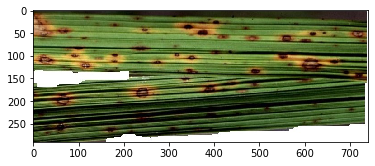

Original label: Leaf smut, Prediction: Brown spot


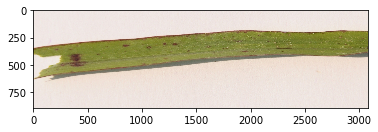

Original label: Leaf smut, Prediction: Brown spot


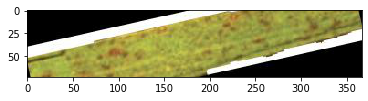

Original label: Leaf smut, Prediction: Brown spot


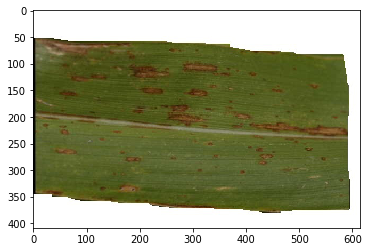

Original label: Bacterial leaf blight, Prediction: Brown spot


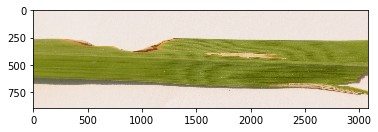

Original label: Bacterial leaf blight, Prediction: Brown spot


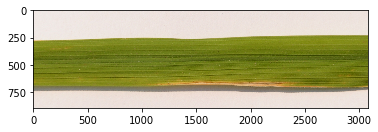

In [54]:
# Visualizing the misclassifications

for i in range(len(errors)):
    num = errors[i]
    print('Original label: {}, Prediction: {}'.format(test['Disease'][num], idx2labels[predictions[num]]))
    images = im.imread(test.Images[num])
    plt.imshow(images)
    plt.show()

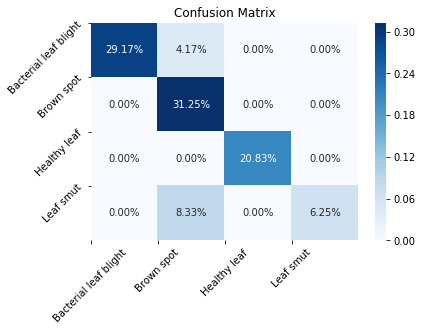

In [55]:
# Plotting a confusion matrix

cm = confusion_matrix(groundtruth, predictions)
sns.heatmap(cm/np.sum(cm), fmt='.2%', cmap='Blues', annot=True)
tick_marks = np.arange(len(idx2labels))
plt.xticks(tick_marks, idx2labels, rotation=45)
plt.yticks(tick_marks, idx2labels, rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [56]:
# Printing the image classification report

print(classification_report(groundtruth, predictions, target_names=idx2labels))

                       precision    recall  f1-score   support

Bacterial leaf blight       1.00      0.88      0.93        16
           Brown spot       0.71      1.00      0.83        15
         Healthy leaf       1.00      1.00      1.00        10
            Leaf smut       1.00      0.43      0.60         7

             accuracy                           0.88        48
            macro avg       0.93      0.83      0.84        48
         weighted avg       0.91      0.88      0.87        48



In [57]:
new_model.save('mymodel_mobilenet.h5') 